<a href="https://colab.research.google.com/github/alexiamhe93/RedditRepairInitiations/blob/main/S2_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S2 - Notebook for inter-rater reliability and classifier validity



# 1. Initiate notebook

This section is required for the notebook to run. It loads all necessary packages, as well as download and load the data.

We recommend running this notebook in Google Colab as it is designed for easy replication (load in Colab - click runtime and "run all"). For an easy accessible version, click here and go to "S2":

https://github.com/alexiamhe93/RedditRepairInitiations

## Load packages

In [1]:
import os
import pandas as pd
# For IRR
from nltk import agreement
# For validation of few-shot algorithm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

## Download and load data

In [2]:
# for downloading data
import requests, zipfile, io
r = requests.get('https://github.com/alexiamhe93/RedditRepairInitiations/blob/main/data.zip?raw=true' )
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
# Load data
try:
  # Few shot validation data
  Prompt_df = pd.read_csv("prompt.csv")
  # Inter-rater reliability data
  IRR_df = pd.read_csv("IRR.csv")
except:
  Prompt_df = pd.read_csv("Data/prompt.csv")
  IRR_df = pd.read_csv("Data/IRR.csv")

# 2. Inter-rater reliability of manually coded data.

The below code calculates the inter-rater reliability of 981 (52% of total manually coded data) comments independently double scored by two coders.

In [5]:


# Function for prepping output
def create_output(df):
  """
  Function converts two coder columns for use in IRR calculations.
  """
  IRR_out = []
  for i, row in df.iterrows():
    for k in list(df.columns):
      IRR_out.append([k, str(i), row[k]])
  return IRR_out

CR_IRR_out = create_output(IRR_df)
# Calculate all other IRR statistics and store them in an NLTK object
ratingtask = agreement.AnnotationTask(data=CR_IRR_out)
# extract the statistics
alpha = round(ratingtask.alpha(),3)
Absolute_agreement = round(ratingtask.avg_Ao(),3)
# Print all the statistics
print("Krippendorf's Alpha " +str(alpha))
print("Absolute Agreement: "+ str(Absolute_agreement))



Krippendorf's Alpha 0.8
Absolute Agreement: 0.952


While the absolute agreement is very high (95%) the inter-rater reliability is lower but still high (alpha = 0.80). This is because most turns do not contain initiations, inflating the overall agreement.

In [7]:
pct_neg = len(IRR_df[IRR_df.CR_A == "_none_"])/len(IRR_df) *100
print(f"Most turns do not contain a repair initiation ({pct_neg:.2f}%)")

Most turns do not contain a repair initiation (86.44%)


# 3. Validation of few-shot algorithm on manually coded data

The full manually coded validation dataset (n=1,897) was used to develop the below prompt, used in few-shot learning using Open AI's [GPT 4](https://openai.com/gpt-4) generative AI model.

```
Prompt = """
ROLE:
You are a research assistant trained to identify whether a Reddit user is asking for clarification using only their post or comment.

BACKGROUND:
Clarification requests are a crucial tool used to enhance comprehension and avoid misunderstandings when faced with unclear or ambiguous communication.
They are essentially questions that help individuals gather more information or confirm their assumptions, promoting precise understanding and reducing the risk of misinterpretation.
The three types of clarification requests are as follows:
Type 1: These are direct expressions of confusion, where the individual seeks a repetition or rephrasing of the original statement.
Type 2: These are targeted inquiries aimed at extracting specific elements or details within the provided information.
Type 3: These involve proposing a suggestion or hypothesis to confirm understanding, essentially narrowing down possibilities to affirm comprehension.
Type 4: A rhetorical question (of types 1-3) that can be answered as if it were a clarification request.
Example: "Is this not somewhat... evident? I'm saying it's just basic reasoning."

Whether you're dealing with complex scenarios or everyday conversations, these types of clarification requests can improve communication and mutual understanding.

QUESTION: Does the below Reddit post or comment contain a request for clarification?
Resond with YES if there is a clarification request. Respond with NO if not.
Only respond with YES or NO.
If the request is rhetorical, respond with YES.

POST/COMMENT:
'''
{}
'''
RESPONSE:
"""
```

The below code reports the result of the algorithm validation (we have also included the training data for reproduction).

In [8]:
def binarize(label):
  if label == "yes":
    return 1
  else:
    return 0

def display_confusion_matrix(true_labels, predicted_labels):
  '''
  Function for displaying a confusion matrix from results
  '''
  conf_mx = confusion_matrix(true_labels, predicted_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx)
  disp.plot()

y_test = Prompt_df[Prompt_df["Train_test"] == "test"]["CR_bin"].to_list()
y_pred = Prompt_df[Prompt_df["Train_test"] == "test"]["GPT_scores"].to_list()
y_test = [binarize(s) for s in y_test]
y_pred= [binarize(s) for s in y_pred]

AUC-ROC: 0.83

AUC-PR: 0.81

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       737
           1       0.88      0.67      0.76       190

    accuracy                           0.91       927
   macro avg       0.90      0.83      0.86       927
weighted avg       0.91      0.91      0.91       927



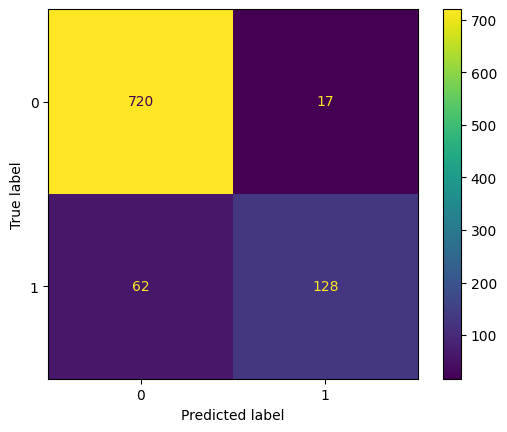

In [9]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {auc_roc:.2f}\n')
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# Calculate AUC-PR
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr:.2f}\n')
print(classification_report(y_test,y_pred))
display_confusion_matrix(y_test, y_pred)

We can see that the algorithm is generally performing well (AUC-PR = 0.81), with a precision of 0.88 for identifying repair initiations. However, the recall is lower (recall = 0.67) meaning the algorithm is missing some true cases of repair inititations.
